# Unit 2 Project Notebook





---



The dataset that I am using comes from a Kaggle submission titled "Predict Test Scores of Students" the link is below: 

https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students

The goal here is to build a classification model that can better predict student test score outcomes so that policy-makers and local school districts can determine where to better allocate their resources.  If many students of the same type are failing, or if there is a predictable trend it is important to be able to leverage the interpretation of this data to help make positive change. 




---



In [ ]:
!pip install category_encoders
!pip install pandas-profiling==2.7.1
!pip install shap

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


# I. Import and Clean Data


---


In [6]:
filepath = 'test_scores.csv'

In [7]:
def wrangle(filepath):
  df = pd.read_csv(filepath)

  # Feature engineer your target variable
  df['passed'] = (df['posttest'] > 68).astype(int)

  # Drop the pretest scores due to data leakage
  df.drop(columns = ['pretest', 'posttest', 'school', 'student_id', 'classroom'], inplace= True)
  
  return df

df = wrangle(filepath)

In [8]:
df.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,passed
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,1
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,1
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,1
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,1
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,1


In [9]:
df['teaching_method'].value_counts()

Standard        1373
Experimental     760
Name: teaching_method, dtype: int64

In [96]:
setting1 = df.loc[df['school_setting'] == 'Urban']
setting2 = df.loc[df['school_setting'] == 'Suburban']
print(setting1['passed'].value_counts(normalize=True))
print(setting2['passed'].value_counts(normalize=True))

0    0.713024
1    0.286976
Name: passed, dtype: float64
1    0.743375
0    0.256625
Name: passed, dtype: float64


In [20]:
# Use the profile report for Exploratory Data Analysis
Report = ProfileReport(df)

Report

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
df.head()
df['passed'].value_counts(normalize=True)

0    0.520863
1    0.479137
Name: passed, dtype: float64

# II. Split Data

In [10]:
# The target vector is 'passed' 1 means passed and 0 means fail
target = 'passed'

y= df[target]
X= df.drop(columns= target)

In [11]:
print(y.shape)
print(X.shape)

(2133,)
(2133, 6)


Here is where I created the training, validation, and test sets.  I took 70% of the total data-set for training and then 50% of that 30% left-over for the validation and testing datasets.  That gives us 70/15/15 split for the Train/Val/Test data. 

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= .3, random_state= 42)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = .5, random_state= 42)

In [14]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1493, 6) (1493,)
(320, 6) (320,)
(320, 6) (320,)


# III. Baseline

Since this is a classification model, the baseline will be the value counts of y_train

In [15]:
# Baseline prediction of 'passed' 

baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5204286671131949


# IV. Build Model

In [16]:
model_dt = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy= 'mean'),
        DecisionTreeClassifier(random_state= 42))

model_dt.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school_setting', 'school_type',
                                      'teaching_method', 'gender', 'lunch'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'school_setting',
                                          'data_type': dtype('O'),
                                          'mapping': Suburban    1
Rural       2
Urban       3
NaN        -2
dtype: int64},
                                         {'col': 'school_type',
                                          'data_type': dtype('O'),...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                  

In [17]:
model_rf = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy= 'mean'),
      RandomForestClassifier(max_samples= .4, n_estimators= 20, random_state= 42, n_jobs= -1))

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school_setting', 'school_type',
                                      'teaching_method', 'gender', 'lunch'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'school_setting',
                                          'data_type': dtype('O'),
                                          'mapping': Suburban    1
Rural       2
Urban       3
NaN        -2
dtype: int64},
                                         {'col': 'school_type',
                                          'data_type': dtype('O'),...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_

In [75]:
model_xgb = make_pipeline(
                OrdinalEncoder(),
                SimpleImputer(strategy='mean'),
                XGBClassifier(n_estimators= 80, random_state= 42, n_jobs= -1, 
                    max_depth= 5, learning_rate= .5))



model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school_setting', 'school_type',
                                      'teaching_method', 'gender', 'lunch'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'school_setting',
                                          'data_type': dtype('O'),
                                          'mapping': Suburban    1
Rural       2
Urban       3
NaN        -2
dtype: int64},
                                         {'col': 'school_type',
                                          'data_type': dtype('O'),...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.5,
                               max_delta_step=0, max_

In [19]:
# Check the metrics of your Decision Tree model

training_acc_dt = accuracy_score(y_train, model_dt.predict(X_train))
val_acc_dt = accuracy_score(y_val, model_dt.predict(X_val))

print('---Decision Tree---')
print('Training Accuracy Score:', training_acc_dt)
print('Validation Accuracy Score:', val_acc_dt)

---Decision Tree---
Training Accuracy Score: 0.9263228399196249
Validation Accuracy Score: 0.909375


In [20]:
# Check the metrics of your Random Forest model

training_acc_rf = accuracy_score(y_train, model_rf.predict(X_train))
val_acc_rf = accuracy_score(y_val, model_rf.predict(X_val))

print('---Random Forest---')
print('Training Accuracy Score:', training_acc_rf)
print('Validation Accuracy Score:', val_acc_rf)

---Random Forest---
Training Accuracy Score: 0.9236436704621568
Validation Accuracy Score: 0.909375


In [76]:
# Check the metrics of your XGBoost model

training_acc_xgb = accuracy_score(y_train, model_xgb.predict(X_train))
val_acc_xgb = accuracy_score(y_val, model_xgb.predict(X_val))
test_acc_xgb = accuracy_score(y_test, model_xgb.predict(X_test))

print('---XGBoost---')
print('Training Accuracy Score:', training_acc_xgb)
print('Validation Accuracy Score:', val_acc_xgb)
print('Test Accuracy Score:', val_acc_xgb)

---XGBoost---
Training Accuracy Score: 0.9263228399196249
Validation Accuracy Score: 0.9125
Test Accuracy Score: 0.9125


In [40]:
cv_scores_dt = cross_val_score(model_dt, X, y, cv= 10, n_jobs= -1)
cv_scores_rf = cross_val_score(model_rf, X, y, cv= 10, n_jobs= -1)
cv_scores_xgb = cross_val_score(model_xgb, X, y, cv= 10, n_jobs= -1)

In [41]:
print(cv_scores_dt.mean())
print(cv_scores_rf.mean())
print(cv_scores_xgb.mean())

0.7160370321618182
0.7206814093282436
0.7076170418147514


According to the Cross-validation Method my Decision Tree model had an accuracy of 71% and my Random Forest model had an accuracy of 72%.  It is worth noting that the dataset may not allow for much hyperparameter tuning due to its simplicity.  More data collected could be necessary to create a more predictive model. 


---
After adding in an XGBoost model, there is an increase in the cross-validation score, which means that the XGBoost may have a better generalized model to use. 


# V. Hyper-Parameter Tuning

In [35]:
# Tune max_depth, n_estimators, and max_samples
# Tuning params by hand makes it easier to see how each parameter is changing

depths = range(1, 10, 1)
estimators = range(10, 100, 10)
learns = (.1, .2, .3, .4, .5, .6)

In [36]:
train_acc = []
val_acc = []

for learn in learns: 

  forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy= 'mean'),
      XGBClassifier(n_estimators= 80, random_state= 42, n_jobs= -1, 
                    max_depth= 5, learning_rate= .5)
  )

  forest_model.fit(X_train, y_train)
  train_acc.append(forest_model.score(X_train, y_train))
  val_acc.append(forest_model.score(X_val, y_val))

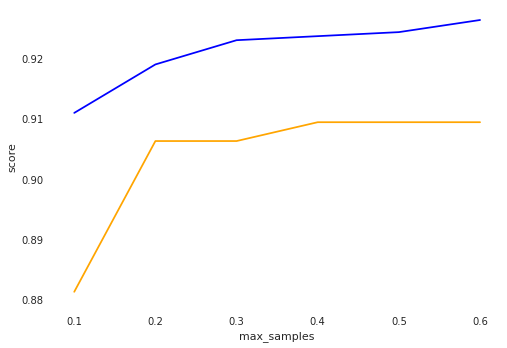

In [60]:
plt.plot(samples, train_acc, color= 'blue', label= 'training')
plt.plot(samples, val_acc, color= 'orange', label= 'validation')
plt.xlabel('max_samples')
plt.ylabel('score')
plt.show()

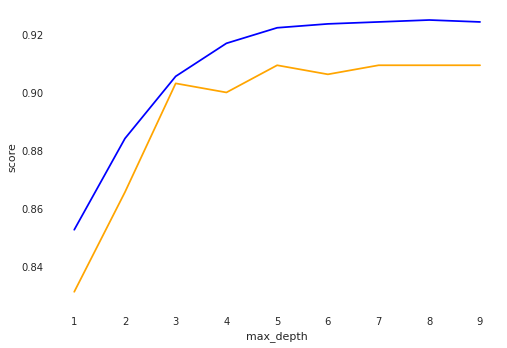

In [34]:
plt.plot(depths, train_acc, color= 'blue', label= 'training')
plt.plot(depths, val_acc, color= 'orange', label= 'validation')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

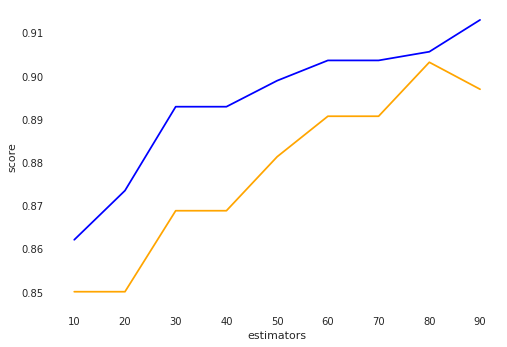

In [26]:
plt.plot(estimators, train_acc, color= 'blue', label= 'training')
plt.plot(estimators, val_acc, color= 'orange', label= 'validation')
plt.xlabel('estimators')
plt.ylabel('score')
plt.show()

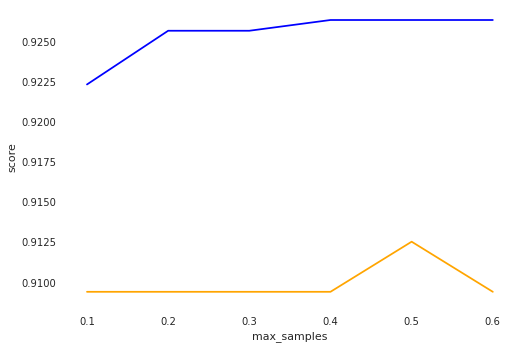

In [37]:
plt.plot(learns, train_acc, color= 'blue', label= 'training')
plt.plot(learns, val_acc, color= 'orange', label= 'validation')
plt.xlabel('max_samples')
plt.ylabel('score')
plt.show()

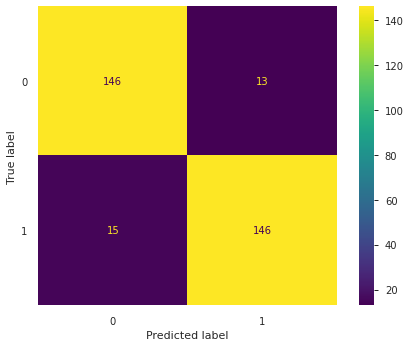

In [42]:
plot_confusion_matrix(model_xgb, X_val, y_val, values_format= '.0f')

In [43]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       159
           1       0.92      0.90      0.91       161

    accuracy                           0.91       320
   macro avg       0.91      0.91      0.91       320
weighted avg       0.91      0.91      0.91       320



# Plot ROC curves

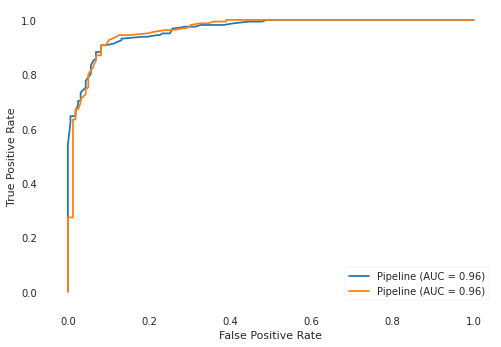

In [54]:
rf = plot_roc_curve(model_rf, X_val, y_val)
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax= rf.ax_)

As we can see both the Random Forest and Extreme Gradient Boosting models perform well, but the XGB model does slightly better in predicting which students will pass. 

# VI. Feature Importances

Look up the feature importances for your model to better understand where there should be increased investment in the education system according to this specific dataset.  

*It is worth noting that this dataset does not have clear sources and is being used more to demonstrate conceptual understanding over creating informed decisions about the current state of the education system*

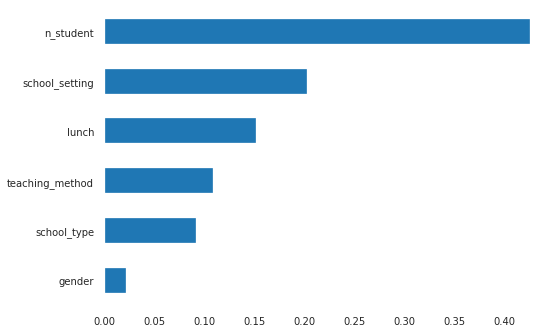

In [87]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data= importances, index= feature_names).sort_values()
feat_imp.tail(6).plot(kind='barh')

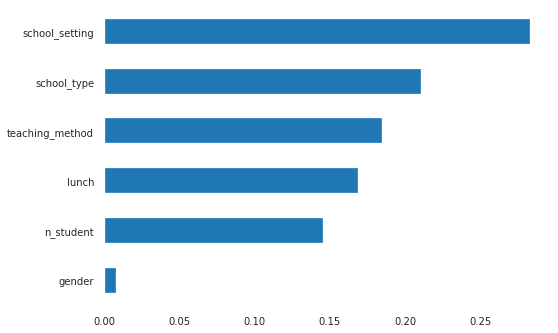

In [44]:
importances_xgb = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names_xgb = X_train.columns
feat_imp_xgb = pd.Series(data= importances_xgb, index= feature_names_xgb).sort_values()
feat_imp_xgb.tail(6).plot(kind= 'barh')

# VII. Shapley Plot

In [51]:
# First you need to fix your data so that you can use it in a shapley plot
# Remember that shapley plots cannot use pipelines so the transformations must be 
# Done beforehand.

shap_pipe = make_pipeline( 
        OrdinalEncoder(),
        SimpleImputer(strategy= 'mean'))

shap_xgb = XGBClassifier(n_estimators= 80, random_state= 42, n_jobs= -1, 
                    max_depth= 5, learning_rate= .5)


shap_train = shap_pipe.fit_transform(X_train, y_train)
shap_test = shap_pipe.fit_transform(X_test, y_test) 

# Fit to your training data
shap_xgb.fit(shap_train, y_train)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [60]:
# Use a samp variable to call your feature names 
shap_test_df = pd.DataFrame(shap_test)
samp = shap_test_df.head(1)
samp

,0,1,2,3,4,5
0,1.0,1.0,2.0,24.0,2.0,2.0


In [63]:
explainer = shap.TreeExplainer(shap_xgb)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values,
                features=samp)

In [70]:
# The labels below will help us to understand our probabilistic shapley plot
interp = pd.DataFrame(df.columns)
interp.columns = ['labels']

interp

,labels
0,school_setting
1,school_type
2,teaching_method
3,n_student
4,gender
5,lunch
6,passed
